<a href="https://colab.research.google.com/github/Ricardomanuel1/Maestria_Ciencia_de_Datos/blob/main/GESTION_ESTADO_PT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [346]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import warnings
import statsmodels.api as sm
import datetime
from datetime import date
from datetime import timedelta
from scipy import stats
warnings.filterwarnings("ignore")

In [347]:
!pip install pandas openpyxl

In [348]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [349]:
#Cargamos el consolidado del informe de operación de las subestaciones

In [350]:
datos = pd.read_excel('/content/drive/MyDrive/INFORME DE OPERACION STN/RESUMEN INFORME DE OPERACION STN_PYTHON.xlsx')

In [351]:
datos.shape

(2934, 25)

## GESTION DE PLANES DE TRABAJO A ESTADO EJECUTADO

In [352]:
#Quitar los los planes de trabajo duplicados

In [353]:
datos_sin_duplicados=datos.drop_duplicates(datos[['PLAN DE TRABAJO']])
datos_sin_duplicados.shape

(1243, 25)

In [354]:
plan=datos_sin_duplicados[["NUMERO DE PERMISO","SUBESTACIÓN","FECHA DE INICIO","PLAN DE TRABAJO","TIPO DE PLAN"]]

In [355]:
pt=plan[["PLAN DE TRABAJO"]]

In [356]:
#Guardamos los planes de trabajo no repetidos para la consulta del estado en SAP

In [357]:
pt.to_csv("/content/drive/MyDrive/INFORME DE OPERACION STN/consulta_SAP.csv",index=False)

In [358]:
#Cargamos la consulta en realizada en SAP de los estados de los planes

In [359]:
sap = pd.read_excel('/content/drive/MyDrive/INFORME DE OPERACION STN/sap_python.XLSX')

In [360]:
#Seleccionamos las 04 primeras columnas

In [361]:
ptsap=sap[['Planes Trab.', 'Estado', 'Núm.Consignación', 'Fecha fin revisión']]
ptsap.columns

Index(['Planes Trab.', 'Estado', 'Núm.Consignación', 'Fecha fin revisión'], dtype='object')

In [362]:
cabecera=['PLAN DE TRABAJO', 'Estado', 'Núm.Consignación', 'Fecha fin revisión']

In [363]:
#Cambiamos el nombre del Planes Trab a PLAN DE TRABAJO de la consulta hecha en SAP

In [364]:
ptsap.columns=cabecera

In [365]:
#Hacemos un merge entre los planes no repetidos(plan) y la consulta en sap(ptsap)

In [366]:
merged_pt = pd.merge(plan,ptsap, on='PLAN DE TRABAJO', how='inner')

In [367]:
merged_pt.head(2)

,NUMERO DE PERMISO,SUBESTACIÓN,FECHA DE INICIO,PLAN DE TRABAJO,TIPO DE PLAN,Estado,Núm.Consignación,Fecha fin revisión
0,64,CARHUAQUERO (ISAP),2023-08-26,R0084687,NACIONAL,8,N84687,2023-08-27
1,54,CARHUAQUERO (ISAP),2023-08-16,R0101338,SIN CONSIGNACIÓN,8,S00000004773,2023-08-17


In [368]:
#Creamos una columna con la fecha de hoy

In [369]:
hoy = date.today()
merged_pt["hoy"]=hoy
merged_pt['hoy'] = pd.to_datetime(merged_pt['hoy'])

In [370]:
merged_pt.head(2)

,NUMERO DE PERMISO,SUBESTACIÓN,FECHA DE INICIO,PLAN DE TRABAJO,TIPO DE PLAN,Estado,Núm.Consignación,Fecha fin revisión,hoy
0,64,CARHUAQUERO (ISAP),2023-08-26,R0084687,NACIONAL,8,N84687,2023-08-27,2023-10-03
1,54,CARHUAQUERO (ISAP),2023-08-16,R0101338,SIN CONSIGNACIÓN,8,S00000004773,2023-08-17,2023-10-03


In [371]:
#Filtramos los sin consignación y local que deben ser cambiados a estado EJECUTADO.

In [372]:
filtro1=merged_pt[(merged_pt.Estado<8) & ((merged_pt["Fecha fin revisión"])<(merged_pt["hoy"]))]
filtro1.head(3)

,NUMERO DE PERMISO,SUBESTACIÓN,FECHA DE INICIO,PLAN DE TRABAJO,TIPO DE PLAN,Estado,Núm.Consignación,Fecha fin revisión,hoy
38,483,CHICLAYO OESTE,2023-10-02,R0102226,SIN CONSIGNACIÓN,2,S00000004804,2023-10-02,2023-10-03


In [373]:
filtro2=filtro1["PLAN DE TRABAJO"]

In [374]:
#Guardamos en el drive los planes que deben ser pasados a EJECUTADO

In [375]:
filtro2.to_csv("/content/drive/MyDrive/INFORME DE OPERACION STN/pasarPTa8.csv",index=False)

##CALCULO DE INDICADORES

In [376]:
datos.head(3)

,NUMERO DE PERMISO,SUBESTACIÓN,FECHA DE INICIO,HORA DE INICIO,PLAN DE TRABAJO,TIPO DE PLAN,INTEGRADOR,PLANES DE TRABAJO DEPENDIENTES,AUTORIZACIÓN CCREP,O.M.,...,EMPRESA,PROPIETARIO DEL ACTIVO,SUPERVISOR DE TRABAJO,SUPERVISOR SUSTITUTO,NUMERO DE TRABAJADORES,ASISTENTE / INGENIERO DE TURNO,FECHA DE FIN,HORA DE FIN,¿SE CONCLUYÓ CON EL TRABAJO?,OBSERVACIONES
0,64,CARHUAQUERO (ISAP),2023-08-26,10:35:16.950000,R0084687,NACIONAL,NO,NO,SI,953365,...,NAZCA ENERGY,ISAP,JAVIER SALAZAR,HENRY PUSE,7.0,KIBERICO,0,0,Permiso abierto,Permiso abierto
1,63,CARHUAQUERO (ISAP),2023-08-25,08:07:51.250000,R0084687,NACIONAL,NO,NO,SI,953365,...,NAZCA ENERGY,ISAP,JAVIER SALAZAR,HENRY PUSE,11.0,KIBERICO,0,0,Permiso abierto,Permiso abierto
2,62,CARHUAQUERO (ISAP),2023-08-24,08:10:00,R0084687,NACIONAL,NO,NO,SI,953365,...,NAZCA ENERGY,ISAP,JAVIER SALAZAR,HENRY PUSE,9.0,KIBERICO,0,0,Permiso abierto,Permiso abierto


In [377]:
filtro11=datos[datos.SUBESTACIÓN==0]
filtro11

,NUMERO DE PERMISO,SUBESTACIÓN,FECHA DE INICIO,HORA DE INICIO,PLAN DE TRABAJO,TIPO DE PLAN,INTEGRADOR,PLANES DE TRABAJO DEPENDIENTES,AUTORIZACIÓN CCREP,O.M.,...,EMPRESA,PROPIETARIO DEL ACTIVO,SUPERVISOR DE TRABAJO,SUPERVISOR SUSTITUTO,NUMERO DE TRABAJADORES,ASISTENTE / INGENIERO DE TURNO,FECHA DE FIN,HORA DE FIN,¿SE CONCLUYÓ CON EL TRABAJO?,OBSERVACIONES


In [385]:
datos.shape

(2934, 25)

In [403]:
from numpy import median

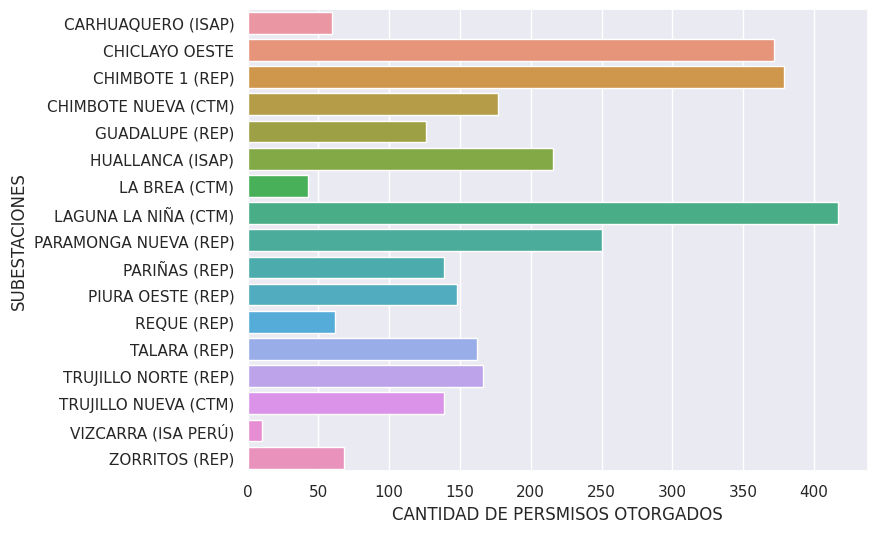

In [452]:
sns.set(rc={"figure.figsize":(8, 6)})
sns.countplot(data=datos, y="SUBESTACIÓN")
plt.ylabel("SUBESTACIONES")
plt.xlabel("CANTIDAD DE PERSMISOS OTORGADOS");

In [395]:
datos["SUBESTACIÓN"].value_counts()

LAGUNA LA NIÑA (CTM)     417
CHIMBOTE 1 (REP)         379
CHICLAYO OESTE           372
PARAMONGA NUEVA (REP)    250
HUALLANCA (ISAP)         216
CHIMBOTE NUEVA (CTM)     177
TRUJILLO NORTE (REP)     166
TALARA (REP)             162
PIURA OESTE (REP)        148
TRUJILLO NUEVA (CTM)     139
PARIÑAS (REP)            139
GUADALUPE (REP)          126
ZORRITOS (REP)            68
REQUE (REP)               62
CARHUAQUERO (ISAP)        60
LA BREA (CTM)             43
VIZCARRA (ISA PERÚ)       10
Name: SUBESTACIÓN, dtype: int64

<Axes: xlabel='count', ylabel='ASISTENTE / INGENIERO DE TURNO'>

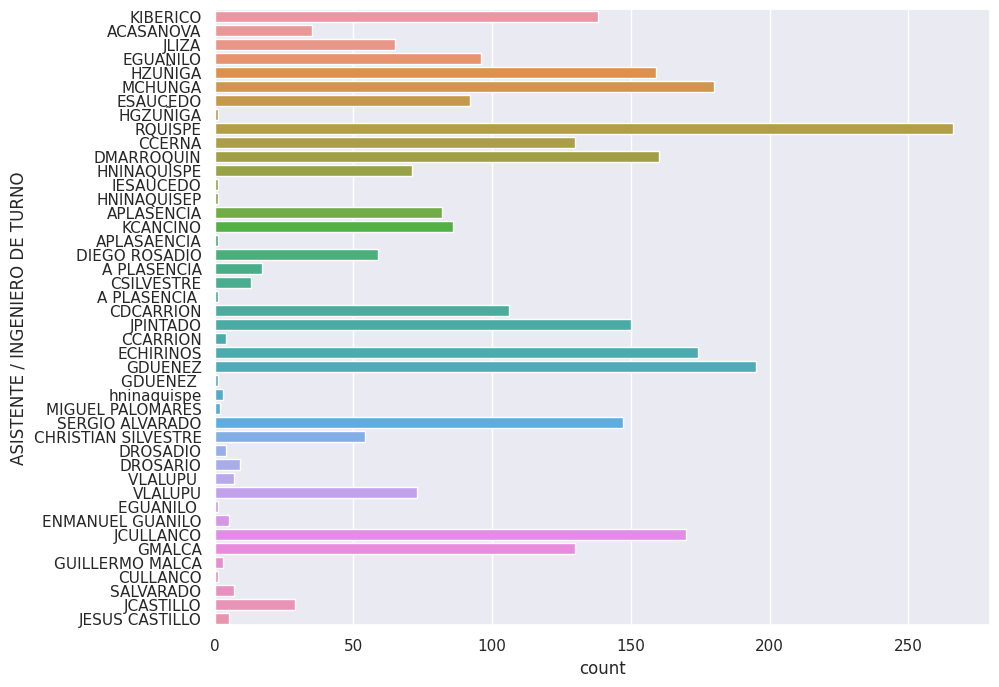

In [401]:
sns.set(rc={"figure.figsize":(10, 8)})
sns.countplot(data=datos, y="ASISTENTE / INGENIERO DE TURNO")

In [396]:
datos["ASISTENTE / INGENIERO DE TURNO"].value_counts()

RQUISPE                266
GDUENEZ                195
MCHUNGA                180
ECHIRINOS              174
JCULLANCO              170
DMARROQUIN             160
HZUÑIGA                159
JPINTADO               150
SERGIO ALVARADO        147
KIBERICO               138
CCERNA                 130
GMALCA                 130
CDCARRION              106
EGUANILO                96
ESAUCEDO                92
KCANCINO                86
APLASENCIA              82
VLALUPU                 73
HNINAQUISPE             71
JLIZA                   65
DIEGO ROSADIO           59
CHRISTIAN SILVESTRE     54
ACASANOVA               35
JCASTILLO               29
A PLASENCIA             17
CSILVESTRE              13
DROSARIO                 9
SALVARADO                7
VLALUPU                  7
ENMANUEL GUANILO         5
JESUS CASTILLO           5
DROSADIO                 4
CCARRION                 4
GUILLERMO MALCA          3
hninaquispe              3
MIGUEL PALOMARES         2
GDUENEZ                  1
H